In [189]:
'''
Created on 2023-12-20 11:59:34
@author: caitgrasso
'''

'\nCreated on 2023-12-20 11:59:34\n@author: caitgrasso\n'

## Network Analysis

First...
1. run network_analysis/community_detection_main.m
2. run network_analysis/degree_distributions.m


In [22]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import igraph as ig
from scipy.stats import spearmanr


In [23]:
# Load data for all explants and store in dictionaries

bots = ['bot_01', 'bot_02', 'bot_03', 'bot_04', 'bot_05', 'bot_06']

pixels_dict = {}
com_dict = {}
distance_mat_dict = {}
series_dict = {}
fc_dict = {}
dd_dict = {}
null_dd_dict = {}
consensus_partition_dict = {}

for BOT in bots:
    pixels_dict[BOT] = {}
    com_dict[BOT] = {}
    series_dict[BOT] = {}
    fc_dict[BOT] = {}
    dd_dict[BOT] = {}
    null_dd_dict[BOT] = {}
    consensus_partition_dict[BOT] = {}
    distance_mat_dict[BOT] = {}

    # Spatial data
    pixels_dict[BOT]['before'] = pd.read_csv('spatial_data/raw_spatial/{}_before_pixels.csv'.format(BOT), header=0)
    pixels_dict[BOT]['after'] = pd.read_csv('spatial_data/raw_spatial/{}_after_pixels.csv'.format(BOT), header=0)

    com_dict[BOT]['before'] = pd.read_csv('spatial_data/raw_spatial/{}_before_centroids.csv'.format(BOT), header=0)
    com_dict[BOT]['after'] = pd.read_csv('spatial_data/raw_spatial/{}_after_centroids.csv'.format(BOT), header=0)

    distance_mat_dict[BOT]['before'] =  np.loadtxt('spatial_data/distance_matrices/distmat_{}_before_centroids.csv'.format(BOT), delimiter=',')
    distance_mat_dict[BOT]['after'] =  np.loadtxt('spatial_data/distance_matrices/distmat_{}_after_centroids.csv'.format(BOT), delimiter=',')

    # Time series (choose data preprocessing mode)
    series_dict[BOT]['before'] = np.loadtxt('network_inference_data/series_raw/{}_before_series.csv'.format(BOT), delimiter=',')
    series_dict[BOT]['after'] = np.loadtxt('network_inference_data/series_raw/{}_after_series.csv'.format(BOT), delimiter=',')

    # FC matrices
    fc_dict[BOT]['before'] = np.loadtxt('network_inference_data/fc_matrices/{}_before_mimat_w.csv'.format(BOT), delimiter=',')
    fc_dict[BOT]['after'] = np.loadtxt('network_inference_data/fc_matrices/{}_after_mimat_w.csv'.format(BOT), delimiter=',')
    
    fc_dict[BOT]['after_u'] = np.loadtxt('network_inference_data/fc_matrices/{}_after_mimat_u.csv'.format(BOT), delimiter=',')
    fc_dict[BOT]['before_u'] = np.loadtxt('network_inference_data/fc_matrices/{}_before_mimat_u.csv'.format(BOT), delimiter=',')

    fc_dict[BOT]['after_no_spiking'] = np.loadtxt('network_inference_data/fc_matrices_synthetic/{}_after_mimat_w_nospikes.csv'.format(BOT), delimiter=',')

    # Degree distributions
    dd_dict[BOT]['before'] = np.loadtxt(f'network_analysis_data/degree_distributions/{BOT}_before_mimat_w_degree_distribution.csv', delimiter=',')
    dd_dict[BOT]['after'] = np.loadtxt(f'network_analysis_data/degree_distributions/{BOT}_after_mimat_w_degree_distribution.csv', delimiter=',')
    
    dd_dict[BOT]['after_u'] = np.loadtxt(f'network_analysis_data/degree_distributions/{BOT}_after_mimat_u_degree_distribution.csv', delimiter=',')
    dd_dict[BOT]['before_u'] = np.loadtxt(f'network_analysis_data/degree_distributions/{BOT}_before_mimat_u_degree_distribution.csv', delimiter=',')

    dd_dict[BOT]['after_no_spiking'] = np.loadtxt(f'network_analysis_data/degree_distributions/{BOT}_after_mimat_w_nospikes_degree_distribution.csv', delimiter=',')

    # Null degree distributions - only have this for the gsr+w case, would have to regenerate null distributions for other preprocessing modes
    null_dd_dict[BOT]['before'] = np.loadtxt(f'network_analysis_data/null_degree_distributions/{BOT}_before.csv', delimiter=',')
    null_dd_dict[BOT]['after'] = np.loadtxt(f'network_analysis_data/null_degree_distributions/{BOT}_after.csv', delimiter=',')

    # Modularity consensus partitions
    consensus_partition_dict[BOT]['before'] = np.loadtxt(f'network_analysis_data/community_detection/{BOT}_before_mimat_w_consensus_partition.csv', delimiter=',')
    consensus_partition_dict[BOT]['after'] = np.loadtxt(f'network_analysis_data/community_detection/{BOT}_after_mimat_w_consensus_partition.csv', delimiter=',')
    
    consensus_partition_dict[BOT]['after_u'] = np.loadtxt(f'network_analysis_data/community_detection/{BOT}_after_mimat_u_consensus_partition.csv', delimiter=',')
    consensus_partition_dict[BOT]['before_u'] = np.loadtxt(f'network_analysis_data/community_detection/{BOT}_before_mimat_u_consensus_partition.csv', delimiter=',')

    consensus_partition_dict[BOT]['after_no_spiking'] = np.loadtxt(f'network_analysis_data/community_detection/{BOT}_after_mimat_w_nospikes_consensus_partition.csv', delimiter=',')




### Plotting functions

In [24]:
# Blind scatter plot for before and after
def plot_blind_scores(before, after, blind, ci, ylabel):

    fig = plt.figure(figsize=(1,5))
    gs = fig.add_gridspec(1,1)
    ax = plt.subplot(gs[0,0])

    before_color = 'tab:blue'
    after_color = 'tab:orange' if not blind else 'tab:blue'

    if ci:
        for i in range(len(before)):

            ax.scatter(0,np.mean(before[i]),c=before_color)
            ax.scatter(0,np.mean(after[i]), c=after_color)
    
    else:
        ax.scatter((0,)*len(before),before,c=before_color)
        ax.scatter((0,)*len(after),after,c=after_color)

    ax.set_ylabel(ylabel)
    ax.get_xaxis().set_visible(False)

    plt.show()

In [25]:
# Plot difference between a baseline group and treatment groups (X)
def plot_differences(baseline_group, X, labels, ylabel):

    fig, ax = plt.subplots(figsize=(7,3),layout='constrained')

    ticks = labels

    assert len(X) == len(labels)

    Xdiff = []
    for i in range(len(X)): # for each treatment group
        Xdiff.append([])

        for j in range(len(X[i])): # for each bot
        
            if type(X[i][j]) is not float or type(X[i][j]) is not int:
                Xdiff[i].append(np.mean(baseline_group[j])-np.mean(X[i][j])) # if there's multiple values per graph (i.e. per node, edge, or community)
            else:
                Xdiff[i].append(baseline_group[j]-X[i][j]) # if there's a single score per graph

    x = np.arange(1,len(Xdiff)+1)

    bxplot = plt.boxplot(Xdiff, positions=x, widths=0.2, patch_artist=True)

    for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bxplot[item], color='dimgray') 
    plt.setp(bxplot["boxes"], facecolor = 'lightgray')
    plt.setp(bxplot["fliers"], markeredgecolor='dimgray')

    plt.xticks(x, ticks, fontweight='bold', fontsize=15)
    # plt.ylim([0, h+0.25])
    ax.tick_params(axis='y', which='major', labelsize=12)

    plt.ylabel(ylabel, fontweight='bold', fontsize=10)

    plt.axhline(0, 0, 6, c='r', ls='--')

    plt.show()



### Modularity analysis

Module sizes

In [35]:
baseline = []
groups = []
i = 0

for label in ['before_u', 'after_u']:
    if label != 'before':
        groups.append([])
    for bot in consensus_partition_dict:

        partition = consensus_partition_dict[bot][label]
        mod_sizes = np.asarray(list(Counter(partition).values()), dtype=int)

        # Remove singleton modules
        # mod_sizes = mod_sizes[mod_sizes!=1]

        # Normalize by the number of nodes in the network
        mod_sizes = [a/len(partition) for a in mod_sizes] 

        max_mod_size = np.max(mod_sizes)
        
        if label=='before':
            baseline.append(max_mod_size)
        else:
            groups[i].append(max_mod_size)
    i+=1

In [36]:
groups

[[0.13135593220338984,
  0.20588235294117646,
  0.14682539682539683,
  0.16356877323420074,
  0.03864734299516908,
  0.11458333333333333],
 [0.0746606334841629,
  0.11009174311926606,
  0.14173228346456693,
  0.10606060606060606,
  0.12883435582822086,
  0.33962264150943394]]

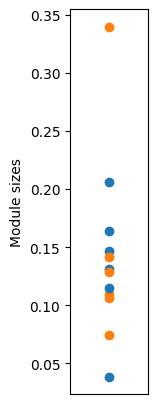

In [38]:
plot_blind_scores(groups[0], groups[1], blind=False, ci=True, ylabel='Module sizes')

In [ ]:
plot_differences(baseline, groups, ['after', 'after (no spiking)'], 'delta mean module size')

Modularity score

In [40]:
baseline = []
groups = []
i=0 

for i,label in enumerate(['before_u', 'after_u']):
    if label != 'before':
        groups.append([])
    for bot in fc_dict:

        FC = fc_dict[bot][label]
        g = ig.Graph.Weighted_Adjacency(FC, mode='undirected')
        g.simplify(multiple=False,loops=True) # remove any self loops

        partition = consensus_partition_dict[bot][label]

        modularity = g.modularity(membership=partition, weights=g.es['weight'])

        if label=='before':
            baseline.append(modularity)
        else:
            groups[i].append(modularity)

    i+=1

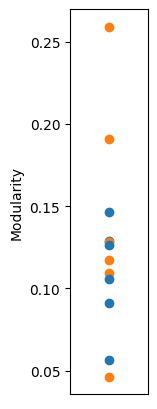

In [42]:
plot_blind_scores(groups[0], groups[1], blind=False, ci=True, ylabel='Modularity')

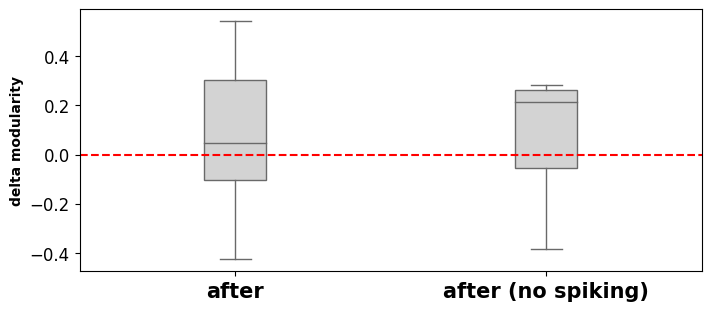

In [253]:
plot_differences(baseline, groups, ['after', 'after (no spiking)'], 'delta modularity')

### Degree distribution analysis

In [43]:
baseline = []
groups = []
i = 0

for label in ['before_u', 'after_u', 'after_no_spiking']:
    if label != 'before':
        groups.append([])
    for bot in dd_dict:

        dd = dd_dict[bot][label]

        if label=='before':
            baseline.append(dd)
        else:
            groups[i].append(dd)

    i+=1


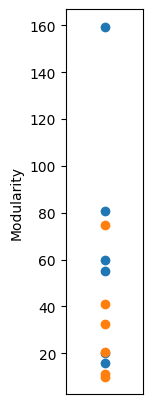

In [45]:
plot_blind_scores(groups[0], groups[1], blind=False, ci=True, ylabel='Modularity')

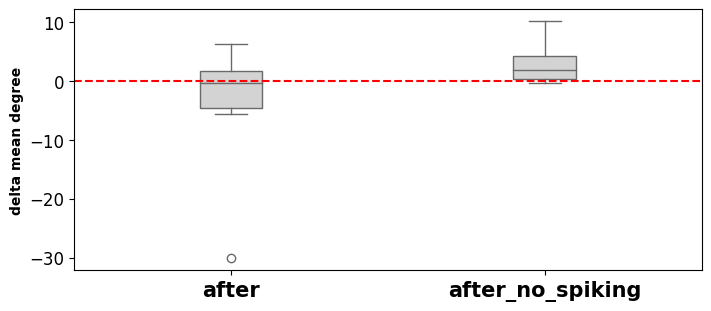

In [250]:
plot_differences(baseline, groups, ['after','after_no_spiking'], 'delta mean degree')

### Distance analysis

In [49]:
baseline = []
groups = []
i = 0

distmat_labels = ['before','after']

for j,label in enumerate(['before_u', 'after_u']):
    if label != 'before':
        groups.append([])
    for bot in fc_dict:

        distmat = distance_mat_dict[bot][distmat_labels[j]]

        fc = fc_dict[bot][label]

        # Get unique edges because the FC and SC mats are symmetric
        fc_edges = fc[np.triu_indices(fc.shape[0],k=1)]

        sc_edges = distmat[np.triu_indices(distmat.shape[0],k=1)]

        # Remove edges with 0 functional connectivity
        fc_edges_pruned = fc_edges[fc_edges!=0]
        sc_edges_pruned = sc_edges[fc_edges!=0]

        stat1, p1 = spearmanr(sc_edges_pruned, fc_edges_pruned)

        if label=='before':
            baseline.append(stat1)
        else:
            groups[i].append(stat1)

    i+=1


print(baseline)
print(groups)
    

[]
[[-0.005907596877914575, -0.06047759844332937, -0.14022673771680716, -0.16747724320365517, -0.0596897731852566, -0.3427195150172433], [-0.08689609362264995, -0.08182071680426123, -0.17583801419077447, -0.1104311682106908, -0.14363283365291815, -0.09033260681721457]]


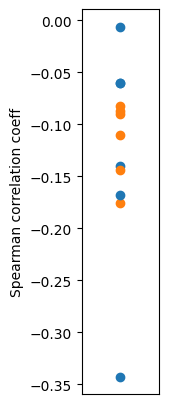

In [51]:
plot_blind_scores(groups[0], groups[1], blind=False, ci=True, ylabel='Spearman correlation coeff')

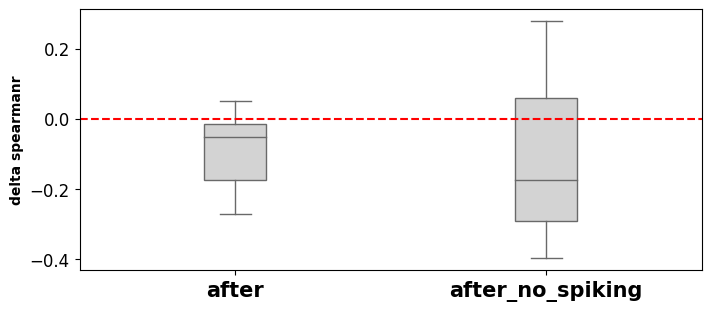

In [245]:
plot_differences(baseline,groups,['after','after_no_spiking'],'delta spearmanr')

In [53]:
baseline = []
groups = []
i = 0
distmat_labels = ['before','after']

for j,label in enumerate(['before_u', 'after_u']):
    if label != 'before':
        groups.append([])
    for bot in fc_dict:

        
        distmat = distance_mat_dict[bot][distmat_labels[j]]

        fc = fc_dict[bot][label]

        FC_unique_edges = fc[np.triu_indices(fc.shape[0],k=1)]
        distmat_unique_edges = distmat[np.triu_indices(distmat.shape[0],k=1)]

        # Remove edges with 0 functional connectivity
        FC_pruned = FC_unique_edges[FC_unique_edges!=0]
        distmat_pruned = distmat_unique_edges[FC_unique_edges!=0]

        weighted_sum = [a*b for a,b in zip(FC_pruned,distmat_pruned)]

        norm_dist = [a/np.max(distmat_unique_edges)/np.max(FC_pruned) for a in weighted_sum] # normalized by the maximum distance between nodes and max FC

        # norm_nonweight_dist = [a/np.max(distmat_pruned) for a in distmat_pruned]

        if label=='before':
            baseline.append(norm_dist)
        else:
            groups[i].append(norm_dist)
    i+=1


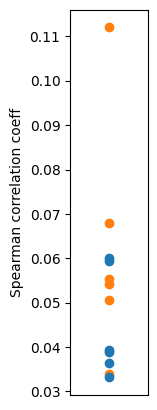

In [55]:
plot_blind_scores(groups[0], groups[1], blind=False, ci=True, ylabel='Spearman correlation coeff')

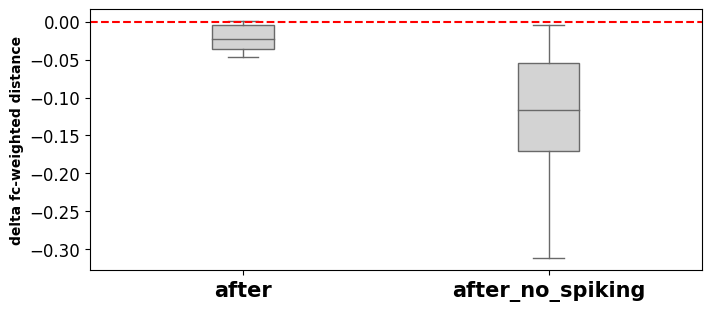

In [263]:
plot_differences(baseline,groups,['after','after_no_spiking'],'delta fc-weighted distance')